In [1]:
import torch as tc 
from torch import optim, nn 
from torch.utils.data import DataLoader, TensorDataset, random_split 

from torchmetrics import Accuracy 

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
 
from tqdm import tqdm

/home/ahmadrezabaqerzadeh/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
xtrain = tc.load('/home/ahmadrezabaqerzadeh/datasets/home-work-transformer/dataset/x_train.pt')
ytrain = tc.load('/home/ahmadrezabaqerzadeh/datasets/home-work-transformer/dataset/y_train.pt')

xvalid = tc.load('/home/ahmadrezabaqerzadeh/datasets/home-work-transformer/dataset/x_valid.pt')
yvalid = tc.load('/home/ahmadrezabaqerzadeh/datasets/home-work-transformer/dataset/y_valid.pt')

xtest = tc.load('/home/ahmadrezabaqerzadeh/datasets/home-work-transformer/dataset/x_test.pt')
ytest = tc.load('/home/ahmadrezabaqerzadeh/datasets/home-work-transformer/dataset/y_test.pt')

In [3]:
xtrain.shape, ytrain.shape

(torch.Size([7500, 2, 3000]), torch.Size([7500]))

In [4]:
xvalid.shape, yvalid.shape

(torch.Size([4094, 2, 3000]), torch.Size([4094]))

In [5]:
xtest.shape, ytest.shape

(torch.Size([9850, 2, 3000]), torch.Size([9850]))

In [6]:
#L
xtrain.shape[2]

3000

In [7]:
#F
xtrain.shape[1]

2

In [8]:
xtrain = xtrain.permute(0, 2, 1)
xvalid = xvalid.permute(0, 2, 1)
xtest  = xtest.permute(0, 2, 1)

ytrain = tc.LongTensor(np.array(ytrain))
yvalid = tc.LongTensor(np.array(yvalid))
ytest  = tc.LongTensor(np.array(ytest))

In [9]:
ytrain.unique()

tensor([0, 1, 2, 3, 4])

In [10]:
mean = xtrain.mean(dim = [0, 1])
std  = xtrain.std(dim = [0, 1])

In [11]:
#xtrain = (xtrain - mean)/std 
#xvalid = (xvalid - mean)/std 
#xtest  = (xtest  - mean)/std

In [12]:
train_dataset = TensorDataset(xtrain, ytrain)
valid_dataset = TensorDataset(xvalid, yvalid)
test_daatset  = TensorDataset(xtest, ytest)

In [13]:
train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = 256, shuffle = False)

In [14]:
x, y = next(iter(train_loader))

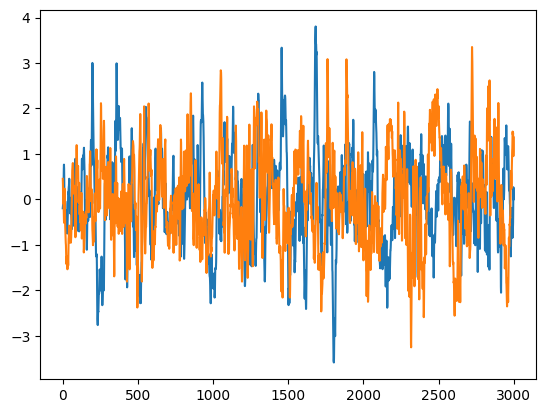

In [15]:
plt.plot(x[0])

In [16]:
device = 'cuda' if tc.cuda.is_available() else 'cpu'

In [17]:
device

'cuda'

In [18]:
class PositionalEncoding(nn.Module):
    
    def __init__(self, L, F):
        super().__init__()
        
        self.position_mat = tc.randn(L, F)
        self.L = L
        self.F = F
    
    def forward(self, x):
        d = self.F
        for t in range(0, self.L):
            for i in range(0, d):
                
                if i%2 ==0:
                    w_k = 1/(1e4**(i/(2*d)))
                    self.position_mat[t][i] = np.sin(w_k * t)
                else:
                    w_k = 1/(1e4**((i-1)/(2*d)))
                    self.position_mat[t][i] = np.cos(w_k * t)
                
        pos  = x + self.position_mat.to(device)
       
        
        return pos

In [19]:
pos = PositionalEncoding(x.shape[1], x.shape[2])(x.to(device))

In [20]:
pos.shape

torch.Size([128, 3000, 2])

In [21]:
x[0]

tensor([[-0.1927,  0.4541],
        [-0.1498,  0.3494],
        [-0.0831,  0.0985],
        ...,
        [ 0.2688,  0.9528],
        [ 0.2488,  1.0680],
        [ 0.0054,  1.3645]])

In [22]:
x[0].to(device) - pos[0]

tensor([[ 0.0000, -1.0000],
        [-0.8415, -0.5403],
        [-0.9093,  0.4161],
        ...,
        [ 0.0793, -0.9969],
        [-0.7960, -0.6053],
        [-0.9394,  0.3427]], device='cuda:0')

In [23]:
class TransformerModel(nn.Module):
    
    def __init__(self, length, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout, activation, num_classes):
        super().__init__()
        
        self.pos = PositionalEncoding(x.shape[1], x.shape[2])
        
        self.encoder = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout, activation, batch_first = True).encoder
        self.fc = nn.LazyLinear(num_classes)
        
        #Expand
        self.linear = nn.LazyLinear(d_model)
        self.bn = nn.LazyBatchNorm1d()
        
        #positional encoder
        self.pos = PositionalEncoding(length, d_model)
        
        #convolutional layers
        self.conv1 = nn.LazyConv1d(1024, 3, 1, 1)
        self.bn1 = nn.LazyBatchNorm1d()
        self.mpool = nn.MaxPool1d(2, 1, 1)
        
        self.conv2 = nn.LazyConv1d(length, 3, 1, 1)
        self.bn2 = nn.LazyBatchNorm1d()
        self.apool = nn.AdaptiveAvgPool1d(output_size = d_model)
        
        self.fc_conv = nn.LazyLinear(d_model)
        
    def forward(self, x):
        
        #convolutional layer1
        x = self.conv1(x)
        x = self.bn1(x)
        x = x.relu()
        x = self.mpool(x)
    
        #convolutional layer2
        x = self.conv2(x)
        x = self.bn2(x)
        x = x.relu()
        x = self.apool(x)
        
        x = self.fc_conv(x)
        
        #positional encoding
        x = self.pos(x)
        
        #encoder
        y = self.encoder(x)
        y = y.flatten(1)
        y = self.fc(y)
        
        return y

In [24]:
model = TransformerModel(64, 32, 4, 2, 0, 16, 0.1, nn.ReLU(), 5).to(device)

/home/ahmadrezabaqerzadeh/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [25]:
model(x.to(device)).shape

torch.Size([128, 5])

In [26]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [27]:
def train_one_epoch(model, train_loader, loss_func, optimizer, epoch):
    model.train()

    train_loss=AverageMeter()
    train_acc=Accuracy(task='multiclass', num_classes=5).to(device)

    with tqdm(train_loader, unit='batch') as tepoch:
        for x, y in tepoch:
            if epoch is not None:
                tepoch.set_description(f'Epoch={epoch}')

            x=x.to(device)
            y=y.to(device)

            yp=model(x)
        
            loss=loss_func(yp.squeeze(),  y)
            loss.backward()
            #nn.utils.clip_grad_norm(model.parameters(), 0.5)
            optimizer.step()
            optimizer.zero_grad()

            train_loss.update(loss.item())
            train_acc(yp.squeeze(), y.int())

            tepoch.set_postfix(loss=train_loss.avg, Accuracy=train_acc.compute().item() * 100)

    return model, train_loss.avg, train_acc.compute().item()

In [28]:
def validation(model, valid_loaedr, loss_func):
    model.eval()

    valid_loss=AverageMeter()
    valid_acc=Accuracy(task='multiclass', num_classes=5).to(device)

    for x, y in valid_loaedr:

        x=x.to(device)
        y=y.to(device)

        yp=model(x)
        loss=loss_func(yp.squeeze(), y)

        valid_loss.update(loss.item())
        valid_acc(yp.squeeze(), y)

    print(f'valid loss={valid_loss.avg:.4}, accuracy={valid_acc.compute().item() * 100 :.4}')
    print()

    return valid_loss.avg, valid_acc.compute().item()

In [98]:
model = TransformerModel(256, 32, 4, 2, 0, 16, 0.1, nn.ReLU(), 5).to(device)

In [99]:
model(x.to(device)).shape

torch.Size([128, 5])

In [100]:
yp = model(x.to(device))
nn.CrossEntropyLoss()(yp, y.to(device))

tensor(1.6776, device='cuda:0', grad_fn=<NllLossBackward0>)

In [101]:
mini_batch, _ = random_split(train_dataset, (50, len(train_dataset) - 50))
mini_loader  = DataLoader(mini_batch, batch_size = 4, shuffle = True)

In [30]:
optimizer = optim.SGD(model.parameters(), lr = 0.000001, momentum = 0.9)
loss_func = nn.CrossEntropyLoss()

In [103]:
N = 20
for i in range(N):
    model, _, _ = train_one_epoch(model, mini_loader, loss_func, optimizer, i)

Epoch=19: 100%|██████████| 13/13 [00:01<00:00, 11.02batch/s, Accuracy=32, loss=1.49]  


In [104]:
num_epochs = 5
for lr in [0.9, 0.5, 0.2, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]:
  print(f'LR={lr}')
  model = TransformerModel(256, 32, 4, 2, 0, 16, 0.1, nn.ReLU(), 5).to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum = 0.9)
  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_func, optimizer, epoch)
  print()

LR=0.9


Epoch=4: 100%|██████████| 59/59 [00:08<00:00,  7.15batch/s, Accuracy=20, loss=nan]  



LR=0.5


Epoch=4: 100%|██████████| 59/59 [00:08<00:00,  6.86batch/s, Accuracy=20, loss=nan]  



LR=0.2


Epoch=4: 100%|██████████| 59/59 [00:09<00:00,  6.38batch/s, Accuracy=20, loss=nan]  



LR=0.1


Epoch=4: 100%|██████████| 59/59 [00:08<00:00,  6.60batch/s, Accuracy=20, loss=nan]  



LR=0.01


Epoch=4: 100%|██████████| 59/59 [00:10<00:00,  5.84batch/s, Accuracy=20.3, loss=nan]    



LR=0.001


Epoch=4: 100%|██████████| 59/59 [00:10<00:00,  5.61batch/s, Accuracy=99.8, loss=0.0366]



LR=0.0001


Epoch=4: 100%|██████████| 59/59 [00:10<00:00,  5.62batch/s, Accuracy=37.5, loss=1.47]



LR=1e-05


Epoch=4: 100%|██████████| 59/59 [00:10<00:00,  5.58batch/s, Accuracy=22.8, loss=1.61]



LR=1e-06


Epoch=4: 100%|██████████| 59/59 [00:10<00:00,  5.56batch/s, Accuracy=20.6, loss=1.64]

In [31]:
lr_n=[0.001, 0.00095, 0.0015, 0.002]
wd_n=[0, 1e-4, 1e-5, 1e-6, 1e-7]
result=[]
for lr in lr_n:
  lr_result=[]
  for wd in wd_n:
      model = TransformerModel(256, 32, 4, 2, 0, 16, 0.1, nn.ReLU(), 5).to(device)
      optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum = 0.9)
      N=5
      print(f'LR={lr}, weight_decay={wd}, filter={filter}')

      for i in range(N):

        model,train_loss, train_acc = train_one_epoch(model, train_loader, loss_func, optimizer, i)

        if i==0:
          e1 = train_loss
        if i==N-1:
          e2 = train_loss

      lr_result.append(f'{e1:.4}-{e2:.4}={e1-e2:.4}')
      print()
  result.append(lr_result)

LR=0.001, weight_decay=0, filter=<class 'filter'>


Epoch=4: 100%|██████████| 59/59 [00:08<00:00,  6.87batch/s, Accuracy=99.6, loss=0.0457]



LR=0.001, weight_decay=0.0001, filter=<class 'filter'>


Epoch=4: 100%|██████████| 59/59 [00:09<00:00,  6.46batch/s, Accuracy=99.9, loss=0.0432]



LR=0.001, weight_decay=1e-05, filter=<class 'filter'>


Epoch=4: 100%|██████████| 59/59 [00:10<00:00,  5.44batch/s, Accuracy=99.3, loss=0.0671]



LR=0.001, weight_decay=1e-06, filter=<class 'filter'>


Epoch=4: 100%|██████████| 59/59 [00:10<00:00,  5.53batch/s, Accuracy=99.7, loss=0.0466]



LR=0.001, weight_decay=1e-07, filter=<class 'filter'>


Epoch=4: 100%|██████████| 59/59 [00:10<00:00,  5.69batch/s, Accuracy=99.9, loss=0.0308]



LR=0.00095, weight_decay=0, filter=<class 'filter'>


Epoch=4: 100%|██████████| 59/59 [00:10<00:00,  5.65batch/s, Accuracy=99, loss=0.088]   



LR=0.00095, weight_decay=0.0001, filter=<class 'filter'>


Epoch=4: 100%|██████████| 59/59 [00:10<00:00,  5.65batch/s, Accuracy=99.9, loss=0.0294]



LR=0.00095, weight_decay=1e-05, filter=<class 'filter'>


Epoch=4: 100%|██████████| 59/59 [00:10<00:00,  5.65batch/s, Accuracy=99.8, loss=0.0474]



LR=0.00095, weight_decay=1e-06, filter=<class 'filter'>


Epoch=4: 100%|██████████| 59/59 [00:10<00:00,  5.56batch/s, Accuracy=99.9, loss=0.0267]



LR=0.00095, weight_decay=1e-07, filter=<class 'filter'>


Epoch=4: 100%|██████████| 59/59 [00:10<00:00,  5.67batch/s, Accuracy=99.9, loss=0.0333]



LR=0.0015, weight_decay=0, filter=<class 'filter'>


Epoch=4: 100%|██████████| 59/59 [00:10<00:00,  5.54batch/s, Accuracy=99.8, loss=0.0213]



LR=0.0015, weight_decay=0.0001, filter=<class 'filter'>


Epoch=4: 100%|██████████| 59/59 [00:10<00:00,  5.38batch/s, Accuracy=99.9, loss=0.0191]



LR=0.0015, weight_decay=1e-05, filter=<class 'filter'>


Epoch=4: 100%|██████████| 59/59 [00:10<00:00,  5.55batch/s, Accuracy=99.9, loss=0.0153]



LR=0.0015, weight_decay=1e-06, filter=<class 'filter'>


Epoch=4: 100%|██████████| 59/59 [00:10<00:00,  5.58batch/s, Accuracy=99.8, loss=0.0181]



LR=0.0015, weight_decay=1e-07, filter=<class 'filter'>


Epoch=4: 100%|██████████| 59/59 [00:10<00:00,  5.58batch/s, Accuracy=99.9, loss=0.018] 



LR=0.002, weight_decay=0, filter=<class 'filter'>


Epoch=4: 100%|██████████| 59/59 [00:10<00:00,  5.43batch/s, Accuracy=98.5, loss=0.0478]



LR=0.002, weight_decay=0.0001, filter=<class 'filter'>


Epoch=4: 100%|██████████| 59/59 [00:10<00:00,  5.52batch/s, Accuracy=99.7, loss=0.021] 



LR=0.002, weight_decay=1e-05, filter=<class 'filter'>


Epoch=4: 100%|██████████| 59/59 [00:10<00:00,  5.58batch/s, Accuracy=99.1, loss=0.035] 



LR=0.002, weight_decay=1e-06, filter=<class 'filter'>


Epoch=4: 100%|██████████| 59/59 [00:10<00:00,  5.55batch/s, Accuracy=99.7, loss=0.0212]



LR=0.002, weight_decay=1e-07, filter=<class 'filter'>


Epoch=4: 100%|██████████| 59/59 [00:10<00:00,  5.62batch/s, Accuracy=99.8, loss=0.0164]

In [32]:
pd.DataFrame(result, index = lr_n, columns = wd_n)

,0.000000e+00,1.000000e-04,1.000000e-05,1.000000e-06,1.000000e-07
0.00100,1.798-0.04567=1.752,1.681-0.04318=1.638,1.727-0.06714=1.66,1.752-0.04661=1.705,1.719-0.0308=1.689
0.00095,1.691-0.08795=1.603,1.666-0.02941=1.636,1.675-0.04738=1.628,1.647-0.02673=1.62,1.695-0.03333=1.662
0.00150,2.471-0.0213=2.449,2.643-0.0191=2.624,3.229-0.01528=3.214,2.461-0.01812=2.443,2.567-0.018=2.549
0.00200,3.112-0.04782=3.064,4.327-0.02096=4.306,3.6-0.03503=3.564,4.807-0.02122=4.785,3.202-0.01641=3.186


In [60]:
model = TransformerModel(256, 32, 4, 2, 0, 16, 0.1, nn.ReLU(), 5).to(device)

In [61]:
optimizer = optim.SGD(model.parameters(), lr = 0.00075 ,momentum = 0.9, weight_decay = 1e-4)
loss_func = nn.CrossEntropyLoss()

In [62]:
loss_train_hist, acc_train_hist = [], [] 
loss_valid_hist, acc_valid_hist = [], []
best_model = [0]
best_loss = tc.inf

In [63]:
mini_valid_batch, _ = random_split(valid_dataset, (50, len(valid_dataset) - 50))
mini_valid_loader  = DataLoader(mini_valid_batch, batch_size = 4, shuffle = True)

In [64]:
N = 10
for i in range(N):

  model, train_loss, train_acc = train_one_epoch(model, train_loader, loss_func, optimizer, i)
  valid_loss, valid_acc = validation(model,valid_loader,loss_func)

  acc_train_hist.append(train_acc)
  loss_train_hist.append(train_loss)

  acc_valid_hist.append(valid_acc)
  loss_valid_hist.append(valid_loss)

  if valid_loss<best_loss:
    best_loss = valid_loss
    best_model[0] = model
    print('model saved!')

Epoch=0: 100%|██████████| 59/59 [00:08<00:00,  7.24batch/s, Accuracy=23.3, loss=1.69]


valid loss=1.732, accuracy=15.49

model saved!


Epoch=1: 100%|██████████| 59/59 [00:08<00:00,  7.17batch/s, Accuracy=36.4, loss=1.5] 


valid loss=1.705, accuracy=22.25

model saved!


Epoch=2: 100%|██████████| 59/59 [00:08<00:00,  7.06batch/s, Accuracy=55.6, loss=1.11]


valid loss=1.26, accuracy=47.95

model saved!


Epoch=3: 100%|██████████| 59/59 [00:08<00:00,  7.09batch/s, Accuracy=80.6, loss=0.602]


valid loss=1.803, accuracy=30.56



Epoch=4: 100%|██████████| 59/59 [00:08<00:00,  6.94batch/s, Accuracy=97.4, loss=0.172]


valid loss=1.718, accuracy=40.16



Epoch=5: 100%|██████████| 59/59 [00:08<00:00,  6.86batch/s, Accuracy=99.9, loss=0.0425]


valid loss=2.005, accuracy=36.13



Epoch=6: 100%|██████████| 59/59 [00:08<00:00,  6.69batch/s, Accuracy=100, loss=0.0168] 


valid loss=1.97, accuracy=38.76



Epoch=7: 100%|██████████| 59/59 [00:08<00:00,  6.66batch/s, Accuracy=100, loss=0.0105]


valid loss=2.048, accuracy=38.35



Epoch=8: 100%|██████████| 59/59 [00:08<00:00,  6.75batch/s, Accuracy=100, loss=0.00752]


valid loss=2.119, accuracy=38.08



Epoch=9: 100%|██████████| 59/59 [00:08<00:00,  6.62batch/s, Accuracy=100, loss=0.0058] 


valid loss=2.16, accuracy=38.03



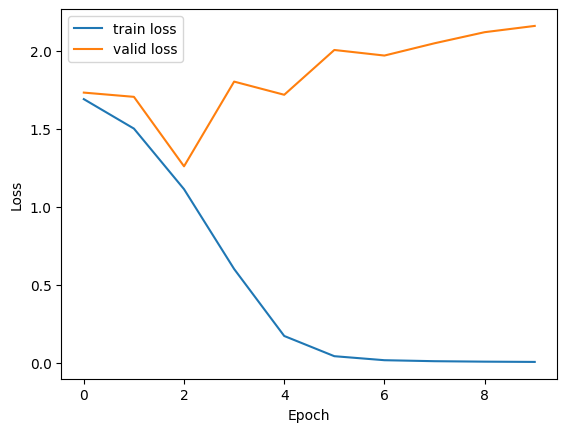

In [65]:
plt.plot(range(N), loss_train_hist, label = 'train loss')
plt.plot(range(N), loss_valid_hist, label = 'valid loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

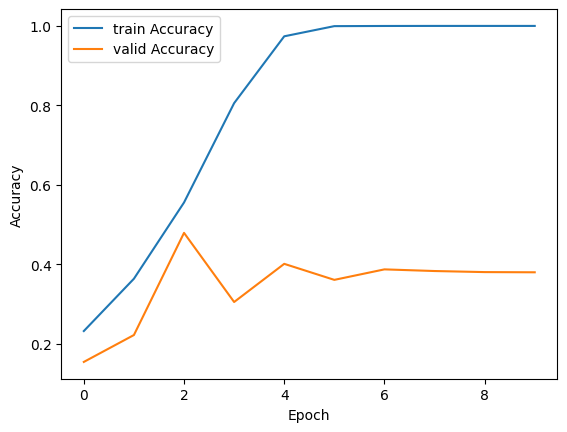

In [66]:
plt.plot(range(N), acc_train_hist, label = 'train Accuracy')
plt.plot(range(N), acc_valid_hist, label = 'valid Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()